* Autora: Andrea Jiménez Zuñiga
* Fecha: 15/01/2021
* Institución: CUNEF

## 1. The World Bank's international debt data
<p>No es que los humanos solo tengamos deudas para administrar nuestras necesidades. Un país también puede endeudarse para administrar su economía. Por ejemplo, el gasto en infraestructura es un ingrediente costoso requerido para que los ciudadanos de un país lleven una vida cómoda. El Banco Mundial es la organización que proporciona deuda a los países.</p>

<!-- <p>En este notebook, vamos a analizar los datos de la deuda internacional recopilados por el Banco Mundial. El conjunto de datos contiene información sobre el monto de la deuda (en USD) que deben los países en desarrollo en varias categorías.</p>  -->

"Disbursements on external debt, long-term (DIS, current US$)",DT.DIS.DLXF.CD
"Interest payments on external debt, long-term (INT, current US$)",DT.INT.DLXF.CD
"PPG, bilateral (AMT, current US$)",DT.AMT.BLAT.CD
"PPG, bilateral (DIS, current US$)",DT.DIS.BLAT.CD
"PPG, bilateral (INT, current US$)",DT.INT.BLAT.CD
"PPG, multilateral (AMT, current US$)",DT.AMT.MLAT.CD
"PPG, multilateral (DIS, current US$)",DT.DIS.MLAT.CD
"PPG, multilateral (INT, current US$)",DT.INT.MLAT.CD
"PPG, official creditors (AMT, current US$)",DT.AMT.OFFT.CD
"PPG, official creditors (DIS, current US$)",DT.DIS.OFFT.CD
"PPG, official creditors (INT, current US$)",DT.INT.OFFT.CD
"Principal repayments on external debt, long-term (AMT, current US$)",DT.AMT.DLXF.CD
"Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$)",DT.INT.DPNG.CD
"PPG, bonds (AMT, current US$)",DT.AMT.PBND.CD
"PPG, bonds (INT, current US$)",DT.INT.PBND.CD
"PPG, commercial banks (AMT, current US$)",DT.AMT.PCBK.CD
"PPG, commercial banks (DIS, current US$)",DT.DIS.PCBK.CD
"PPG, commercial banks (INT, current US$)",DT.INT.PCBK.CD
"PPG, other private creditors (AMT, current US$)",DT.AMT.PROP.CD
"PPG, other private creditors (DIS, current US$)",DT.DIS.PROP.CD
"PPG, other private creditors (INT, current US$)",DT.INT.PROP.CD
"PPG, private creditors (AMT, current US$)",DT.AMT.PRVT.CD
"PPG, private creditors (DIS, current US$)",DT.DIS.PRVT.CD
"PPG, private creditors (INT, current US$)",DT.INT.PRVT.CD
"Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$)",DT.AMT.DPNG.CD

<p>Vamos a encontrar las respuestas a preguntas como:

<p>¿Cuál es el monto total de la deuda que deben los países enumerados en el conjunto de datos?
<p>¿Qué país posee la cantidad máxima de deuda y cómo se ve esa cantidad?
<p>¿Cuál es el monto promedio de la deuda de los países a través de diferentes indicadores de deuda?
    
Además tenemos otro dataset en el que encontramos información histórica de algunos índices de desarrollo, entre los que se encuentran algunos de deuda como son:

Series Name,Series Code
"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN

"Central government debt, total (current LCU)",GC.DOD.TOTL.CN

"Central government debt, total (% of GDP)",GC.DOD.TOTL.GD.ZS

#### 1. Inicializar y cargar el contexto spark

In [1]:
# Librerias que voy a necesitar para inicializar spark, incluyendo el resto de librerias que voy a necesitar
# a lo largo del ejercicio.

import re
from pyspark.sql import functions as f
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark import SparkContext
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 
from pyspark.sql import SQLContext
sc= SparkContext()
from pyspark.sql.functions import desc
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [2]:
# A continuacion cargo las bases de datos

indicadores_desarrollo = spark.read.format('csv') \
                .option('header',True) \
                .option('multiLine', True) \
                .load('indicadores_desarrollo.csv')
            
indicadores_deuda = spark.read.format('csv') \
                .option('header',True) \
                .option('multiLine', True) \
                .load('indicadores_deuda.csv')

A continuación, he realizado cambios en el nombre de ciertas variables para que a la hora de realizar ciertas operaciones no me de problemas. Para ello utilizo _withColumnRenamed_ para renombrar esas columnas.

In [3]:
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.AMT.BLAT.CD','dt_amt_blat_cd')
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.AMT.MLAT.CD' , 'dt_amt_mlat_cd')
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.DIS.BLAT.CD' , 'dt_dis_blat_cd')
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.INT.BLAT.CD' , 'dt_int_blat_cd')
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.AMT.BLAT.CD' , 'dt_amt_blat_cd')
indicadores_deuda = indicadores_deuda.withColumnRenamed('SP.DYN.CBRT.IN' , 'sp_dyn_crbt_in')
indicadores_deuda = indicadores_deuda.withColumnRenamed('DT.AMT.DLXF.CD' , 'dt_amt_dlxf_cd')

Observo la estructura que sigue tanto mi dataset formado por los indicadores de desarrollo como los de deuda.

In [4]:
indicadores_desarrollo.take(1)

[Row(country_name='Albania', country_code='ALB', anho='2014 [YR2014]', GC.DOD.TOTL.CN='1023040800000', GC.DOD.TOTL.GD.ZS='73.3202469198429', SP.DYN.CBRT.IN='12.259')]

In [5]:
indicadores_deuda.take(1)

[Row(country_name='Afghanistan', country_code='AFG', dt_amt_blat_cd='61739336.9', dt_amt_dlxf_cd='100847181.9', DT.AMT.DPNG.CD=None, dt_amt_mlat_cd='39107845', DT.AMT.OFFT.CD='100847181.9', DT.AMT.PBND.CD=None, DT.AMT.PCBK.CD=None, DT.AMT.PROP.CD=None, DT.AMT.PRVT.CD=None, dt_dis_blat_cd='49114729.4', DT.DIS.DLXF.CD='72894453.7', DT.DIS.MLAT.CD='23779724.3', DT.DIS.OFFT.CD='72894453.7', DT.DIS.PCBK.CD=None, DT.DIS.PROP.CD=None, DT.DIS.PRVT.CD=None, dt_int_blat_cd='39903620.1', DT.INT.DLXF.CD='53239440.1', DT.INT.DPNG.CD=None, DT.INT.MLAT.CD='13335820', DT.INT.OFFT.CD='53239440.1', DT.INT.PBND.CD=None, DT.INT.PCBK.CD=None, DT.INT.PROP.CD=None, DT.INT.PRVT.CD=None)]

In [6]:
indicadores_desarrollo.count()

134

In [7]:
indicadores_deuda.count()

124

#### 2. Número de países distintos en cada dataset. Coinciden?

Para poder obtener el número de países distintos que existen tanto en el dataset de indicadores de desarrollo y en el correspondiente al de los indicadores de deuda, es necesario hacer uso de la función ___distinct()___ , ya que esta función me va a devolver un nuevo dataframe que contiene el número de filas distintas en el dataset correspondiente.

   1. Dataset Indicadores de Deuda:

Hay un total de 124 países distintos en el dataset de indicadores de deuda.

In [9]:
paises_deuda = indicadores_deuda.groupBy("country_name").sum().distinct().collect()
len(paises_deuda)

124

   1. Dataset Indicadores de Desarrollo:

Hay un total de 52 países distintos en el dataset de indicadores de desarrollo.

In [10]:
paises_desarrollo = indicadores_desarrollo.groupBy("country_name").sum().distinct().collect()
len(paises_desarrollo)

52

Se puede observar que el número de países distintos en cada dataset no coincide. El dataset de deuda contiene más países que el dataset de desarrollo, presentando 72 países más que el de desarrollo.

#### 3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD

Para calcular el total de deuda contraída por cada país, es necesario calcular la suma de dicha deuda (DT.AMT.MLAT.CD) y agruparlo por países. 

In [34]:
total_deuda_pais = indicadores_deuda.groupby(["country_name"]).agg(f.sum('dt_amt_mlat_cd').alias("Total_deuda"))
total_deuda_pais.show()

+--------------------+--------------+
|        country_name|   Total_deuda|
+--------------------+--------------+
|          South Asia|7.8517399295E9|
|                Chad|  9.57387095E7|
|        EgyptArabRep| 2.424904078E9|
|            Paraguay| 2.076620309E8|
|             Senegal| 1.704379291E8|
|          Cabo Verde|  3.99701249E7|
|      IranIslamicRep|  7.83540608E7|
|Least developed c...|4.0842755242E9|
|              Guyana|  3.46518065E7|
|             Eritrea|  1.54824754E7|
|         Philippines| 7.390564273E8|
|            Djibouti|  3.42549092E7|
|               Tonga|     2791253.2|
|                Fiji|     9082442.6|
|              Turkey| 2.932698678E9|
|              Malawi|  3.56598314E7|
|             Comoros|     2182053.1|
|         Afghanistan|   3.9107845E7|
|            Cambodia|  7.23070018E7|
|              Jordan| 2.704987155E8|
+--------------------+--------------+
only showing top 20 rows



#### 4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD

Para calcular la media de estos indicadores se utiliza la función de agregado que calcula la media.
El indicador que tiene mayor media es el indicador DT.DIS.BLAT.CD.

In [13]:
media_dtamt = indicadores_deuda.agg(f.mean('dt_amt_blat_cd').alias("Media 1")).show()
media_dtamt = indicadores_deuda.agg(f.mean('dt_dis_blat_cd').alias("Media 2")).show()
media_dtamt = indicadores_deuda.agg(f.mean('dt_int_blat_cd').alias("Media 3")).show()


+-------------------+
|            Media 1|
+-------------------+
|7.126196346598358E8|
+-------------------+

+------------------+
|           Media 2|
+------------------+
|1.22313929039823E9|
+------------------+

+-------------------+
|            Media 3|
+-------------------+
|1.640932856090164E8|
+-------------------+



#### 5. Los 20 paises con DT.AMT.DLXF.CD más alto

Para obtener los 20 países con un DT.AMT.DLXF.CD más alto es necesario ordenar de forma descendente dicho indicador, agrupándolos por el nombre del país y el indicador. 

Venezuela es el país con mayor valor de dicho indicador, con un total de 9,878,659,207.2 dólares, mientras que en el último puesto se encuentra Guinea-Bissau, con un total de 6,783,629.1 dólares.


In [14]:
top_20_paises = indicadores_deuda \
.groupby('country_name','dt_amt_dlxf_cd') \
.count() \
.orderBy(f.col("dt_amt_dlxf_cd").desc()) \
.limit(20)
top_20_paises.show()


+---------------+--------------+-----+
|   country_name|dt_amt_dlxf_cd|count|
+---------------+--------------+-----+
|    VenezuelaRB|  9878659207.2|    1|
|  Cote d'Ivoire|   979241934.4|    1|
|   EgyptArabRep|  9692114176.9|    1|
|          China| 96218620835.7|    1|
|        Lebanon|  9506919669.6|    1|
|   South Africa|  9474257551.9|    1|
|         Brazil| 90041840304.1|    1|
|        Vietnam|  8873505909.2|    1|
|   MacedoniaFYR|   875846538.5|    1|
|        Armenia|   845630723.8|    1|
|       Pakistan|  8336013891.3|    1|
|       Djibouti|    83185188.3|    1|
|    Timor-Leste|        825000|    1|
|Kyrgyz Republic|   816419045.1|    1|
|        Ukraine|  8148995625.6|    1|
|        Albania|   790248675.2|    1|
|       Cambodia|   775955981.3|    1|
|        Moldova|     769232867|    1|
|           Togo|    73812591.8|    1|
|  Guinea-Bissau|     6783629.1|    1|
+---------------+--------------+-----+



#### 6. Pais con los datos informados todos los años.

Para obtener los países que contienen datos todos los años hay que, en primer lugar, conocer los distintos años que aparecen en el dataset de los indicadores de desarrollo. Para ello empleamos la función ___distinct()___ sobre los años. 

In [15]:
anho = indicadores_desarrollo.groupBy("anho").sum().distinct().collect()
anho # Hay 4 años distintos

[Row(anho='2016 [YR2016]'),
 Row(anho='2014 [YR2014]'),
 Row(anho='2017 [YR2017]'),
 Row(anho='2015 [YR2015]')]

En dicho dataset, se recogen datos en los años 2014, 2015, 2016 y 2017, es decir, hay un total de 4 años. 
Una vez conocido el número máximo de años en los que los países pueden informar de sus datos, realizamos un filtro (___filter()___) poniendo como condición que el count de los años sea igual a 4, agrupándolo por países.

In [16]:
pais_total_anhos = indicadores_desarrollo.groupby('country_name').count().filter("`count` = 4").show()


+------------+-----+
|country_name|count|
+------------+-----+
|      Malawi|    4|
+------------+-----+



De tal forma obtenemos que el único país con los datos informados todos los años es Malawi.

#### 7.  Media anual de los distintos indicadores de desarrollo

Indicadores de desarrollo: GC.DOD.TOTL.CN, GC.DOD.TOTL.GD.ZS, SP.DYN.CBRT.IN

A continuación, he realizado cambios en el nombre de ciertas variables para que a la hora de realizar ciertas operaciones no me de problemas. Para ello utilizo withColumnRenamed para renombrar esas columnas.

In [17]:
indicadores_desarrollo = indicadores_desarrollo.withColumnRenamed('GC.DOD.TOTL.CN','gc_dod_totl_cn')
indicadores_desarrollo = indicadores_desarrollo.withColumnRenamed('GC.DOD.TOTL.GD.ZS','gc_dod_totl_gd_zs')
indicadores_desarrollo = indicadores_desarrollo.withColumnRenamed('SP.DYN.CBRT.IN','sp_dyn_cbrt_in')


Para calcular la media anual de estos indicadores se utiliza la función de agregado que calcula la media, siendo necesario agruparlos por años.

In [18]:
media_1 = indicadores_desarrollo.groupby("anho").agg(f.mean('gc_dod_totl_cn').alias("Media Indicador 1")).show()
media_2 = indicadores_desarrollo.groupby("anho").agg(f.mean('gc_dod_totl_gd_zs').alias("Media Indicador 2")).show()
media_3 = indicadores_desarrollo.groupby("anho").agg(f.mean('sp_dyn_cbrt_in').alias("Media Indicador 3")).show()



+-------------+--------------------+
|         anho|   Media Indicador 1|
+-------------+--------------------+
|2016 [YR2016]|1.588138215480659...|
|2014 [YR2014]|1.034427587329532...|
|2017 [YR2017]| 2.23985861996269E12|
|2015 [YR2015]|1.318244039159024...|
+-------------+--------------------+

+-------------+------------------+
|         anho| Media Indicador 2|
+-------------+------------------+
|2016 [YR2016]|58.796949624008356|
|2014 [YR2014]|56.843914344384395|
|2017 [YR2017]|   48.659564238322|
|2015 [YR2015]| 58.36559834488036|
+-------------+------------------+

+-------------+------------------+
|         anho| Media Indicador 3|
+-------------+------------------+
|2016 [YR2016]| 16.14433333333333|
|2014 [YR2014]|          17.58262|
|2017 [YR2017]|            34.593|
|2015 [YR2015]|16.798477272727276|
+-------------+------------------+



#### 8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN

El indicador DT.AMT.MLAT.CD corresponde a un indicador de deuda y el indicador SP.DYN.CBRT.IN (tasaa de nacimientos) corresponde a un indicador de desarrollo.

Para poder conocer el total de deuda acumulada por los 10 países con un valor en media menor del indicador de la tasa de nacimientos, es necesario conocer la media de dicha tasa.

In [22]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

indicadores_desarrollo.select(_mean('sp_dyn_cbrt_in')).show()

+-------------------+
|avg(sp_dyn_cbrt_in)|
+-------------------+
| 17.033477611940306|
+-------------------+



Como resultado se obtiene que el indicador que representa la tasa de nacimientos tiene una media de 17.0334.

A continuación, tomo la tabla calculada en el ejercicio 3 que representa el total de deuda de cada país.

In [46]:
total_deuda_pais.show(10)

+--------------------+--------------+
|        country_name|   Total_deuda|
+--------------------+--------------+
|          South Asia|7.8517399295E9|
|                Chad|  9.57387095E7|
|        EgyptArabRep| 2.424904078E9|
|            Paraguay| 2.076620309E8|
|             Senegal| 1.704379291E8|
|          Cabo Verde|  3.99701249E7|
|      IranIslamicRep|  7.83540608E7|
|Least developed c...|4.0842755242E9|
|              Guyana|  3.46518065E7|
|             Eritrea|  1.54824754E7|
+--------------------+--------------+
only showing top 10 rows



Con mi dataset de los indicadores de desarrollo voy a incluir una columna que corresponda a la media del indicador de la tasa de nacimiento agrupados por país, aplicándole un filtro de tal forma que sólo me aparezcan los 10 países cuya media sea menor a 17.0334.

In [50]:
avg_desarrollo = indicadores_desarrollo \
                    .groupby("country_name") \
                    .agg(f.mean('sp_dyn_cbrt_in').alias("Media sp_dyn_cbrt_in")) \
                    .filter("`Media sp_dyn_cbrt_in` < 17.0334") \
                    .sort(("Media sp_dyn_cbrt_in"))
                
avg_desarrollo.show(10)                                                                                           

+------------+--------------------+
|country_name|Media sp_dyn_cbrt_in|
+------------+--------------------+
|       Japan|   7.933333333333334|
|  San Marino|                8.05|
|    KoreaRep|   8.366666666666667|
|       Spain|                 9.0|
|     Hungary|   9.533333333333333|
|   Singapore|   9.633333333333333|
| Switzerland|  10.466666666666667|
|     Ukraine|                10.6|
|     Moldova|  10.604333333333335|
|    Barbados|              10.861|
+------------+--------------------+
only showing top 10 rows



A continuación, realizo un join de tal forma que me una la tabla que representa la deuda total de cada país y la tabla creada anteriormente que representa la media de la tasa de nacimientos por país.

In [58]:
join_avg_pais = total_deuda_pais.join(avg_desarrollo, on="country_name", how = "inner").limit(10)
join_avg_pais.show()

+------------------+--------------+--------------------+
|      country_name|   Total_deuda|Media sp_dyn_cbrt_in|
+------------------+--------------+--------------------+
|            Turkey| 2.932698678E9|  16.717333333333332|
|         Sri Lanka| 4.497719611E8|              16.729|
|           Albania| 1.821976167E8|  12.178666666666667|
|           Belarus|  5.95438826E8|  12.466666666666667|
|Russian Federation|    1.416695E8|  13.166666666666666|
|          Thailand|  3.90715715E7|             10.9175|
|           Ukraine|1.0724728303E9|                10.6|
|           Georgia| 1.440624015E8|              14.056|
|           Jamaica|  1.74427648E8|   16.63566666666667|
|            Brazil|2.5143187416E9|  14.467666666666666|
+------------------+--------------+--------------------+



Como quiero los 10 países con una media menor a 17.0334, los ordeno de forma ascendente. 

In [52]:
total = join_avg_pais.sort(("Media sp_dyn_cbrt_in")).limit(10)
total.show()

+------------------+--------------+--------------------+
|      country_name|   Total_deuda|Media sp_dyn_cbrt_in|
+------------------+--------------+--------------------+
|           Ukraine|1.0724728303E9|                10.6|
|           Moldova| 1.358428655E8|  10.604333333333335|
|          Thailand|  3.90715715E7|             10.9175|
|           Albania| 1.821976167E8|  12.178666666666667|
|           Belarus|  5.95438826E8|  12.466666666666667|
|Russian Federation|    1.416695E8|  13.166666666666666|
|           Georgia| 1.440624015E8|              14.056|
|            Brazil|2.5143187416E9|  14.467666666666666|
|          Colombia|1.1009075536E9|              15.516|
|           Jamaica|  1.74427648E8|   16.63566666666667|
+------------------+--------------+--------------------+



Se puede observar que la deuda acumulada del país con un valor en media menor a la tasa de nacimientos es Ucrania. 

El total de deuda acumulada  por los 10 países con un valor en media menor de la tasa de nacimientos es la que aparece a continuación:


In [45]:
total.agg(f.sum('Total_deuda').alias("total")).show()

+-------------------+
|              total|
+-------------------+
|6.100409554700001E9|
+-------------------+



#### 9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?

Para poder determinar si hay alguna relación entre ambos indicadores, es necesario primero calcular en formato tabla la deuda acumulada por países y los nacimientos.

In [65]:
indicador_deuda = indicadores_deuda.groupby("country_name").agg(f.sum("dt_amt_dlxf_cd").alias('indicador_deuda'))
indicador_deuda.show()

+--------------------+----------------+
|        country_name| indicador_deuda|
+--------------------+----------------+
|          South Asia|4.87562958982E10|
|                Chad|    1.78106958E8|
|        EgyptArabRep|  9.6921141769E9|
|            Paraguay|  1.5285085736E9|
|             Senegal|    4.44722556E8|
|          Cabo Verde|    6.77284459E7|
|      IranIslamicRep|    1.05885317E8|
|Least developed c...|2.51970292994E10|
|              Guyana|   1.082646655E8|
|             Eritrea|    3.11100778E7|
|         Philippines|  6.4791709177E9|
|            Djibouti|    8.31851883E7|
|               Tonga|    1.03699106E7|
|                Fiji|    4.65325085E7|
|              Turkey|5.15550310058E10|
|              Malawi|    5.74223731E7|
|             Comoros|       4792269.1|
|         Afghanistan|   1.008471819E8|
|            Cambodia|   7.759559813E8|
|              Jordan|  1.9903434792E9|
+--------------------+----------------+
only showing top 20 rows



In [60]:
indicador_nacimientos = indicadores_desarrollo.groupby("country_name").agg(f.sum("sp_dyn_cbrt_in").alias('indicador_nacimientos'))
indicador_nacimientos.show()

+--------------------+---------------------+
|        country_name|indicador_nacimientos|
+--------------------+---------------------+
|    MicronesiaFedSts|               46.578|
|         Philippines|               22.935|
|  St Kitts and Nevis|                 12.6|
|               Tonga|               76.087|
|            Malaysia|               51.052|
|           Singapore|                 28.9|
|            KoreaRep|                 25.1|
|              Turkey|               50.152|
|              Malawi|              142.224|
|              Jordan|                48.61|
|               Palau|                 39.4|
|           Sri Lanka|               33.458|
|          San Marino|                 16.1|
|            St Lucia|               12.502|
|   MicronesiaFed.Sts|               23.069|
|             Albania|               36.536|
|                Peru|               55.694|
|       United States|   37.099999999999994|
|             Belarus|                 37.4|
|St Vincen

A continuación, realizo un join de tal forma que me una ambas tablas, pudiendo observar el indicador de deuda y el indicador de la tasa de nacimientos calculados anteriormente.

In [67]:
join = indicador_deuda.join(indicador_nacimientos, on="country_name", how = "inner")
join.show()

+------------------+----------------+---------------------+
|      country_name| indicador_deuda|indicador_nacimientos|
+------------------+----------------+---------------------+
|       Philippines|  6.4791709177E9|               22.935|
|             Tonga|    1.03699106E7|               76.087|
|            Turkey|5.15550310058E10|               50.152|
|            Malawi|    5.74223731E7|              142.224|
|            Jordan|  1.9903434792E9|                48.61|
|         Sri Lanka|  5.7614892559E9|               33.458|
|           Albania|   7.902486752E8|               36.536|
|              Peru|  5.8812599747E9|               55.694|
|           Belarus|  4.6400378842E9|                 37.4|
|Russian Federation|6.65897618335E10|                 39.5|
|          Thailand|  5.9147069983E9|               21.835|
|            Bhutan|   2.132585369E8|   53.373000000000005|
|           Ukraine|  8.1489956256E9|                 31.8|
|           Georgia|  1.5521169536E9|   

Para poder calcular la correlación, es necesario pasar mi dataframe de pyspark a un dataframe de Pandas.

In [68]:
join_pandas = join.toPandas()

Paso los valores que recoge la columna 'indicador_nacimientos' a float para poder calcular la correlación.

In [69]:
join_pandas['indicador_nacimientos'] = join_pandas['indicador_nacimientos'].astype(float)

* __Correlación:__
    Para calcular la correlación he definido lo que va a ser mi x y la y. En este caso la 'x' es el indicador de  nacimientos y la 'y' el indicador de deuda.

In [74]:
x = join_pandas.indicador_nacimientos
y = join_pandas.indicador_deuda

In [80]:
correlation = y.corr(x)
correlation

-0.17107254161023341

La correlación de ambas columnas es de -0.17. Representa una correlación negativa, es decir, representa un relación inversa (cuando aumenta una disminuye la otra). La correlación entre ambas es muy baja, siendo poco representativa.

* __Representación gráfica:__

In [81]:
import numpy as np
import matplotlib.pyplot as plt


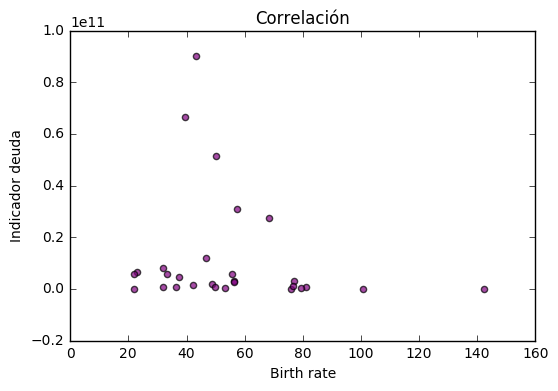

In [82]:
# Plot
colors = 'purple'

plt.scatter(x, y, c=colors, alpha=0.7)
plt.title('Correlación')
plt.xlabel('Birth rate')
plt.ylabel('Indicador deuda')
plt.show()

Se puede observar que la correlación que hay entre la tasa de nacimiento y el indicador de deuda DT.AMT.DLXF.CD, siendo el mismo de -0.17. Esto demuestra que la relación entre ambas no es significativa. 

También ocurre que dicha correlación es negativa, lo cual demuestra que cuando la tasa de nacimientos aumenta, el indicador de deuda DT.AMT.DLXF.CD disminuye. Esto se puede observar en la gráfica. Los datos muestran un patrón descendente a medida que se mueve de izquierda a derecha, esto indica una relación negativa entre X e Y. A medida que los valores X aumentan (se mueven a la derecha) los valores Y tienden a disminuir (se mueven hacia abajo).

